In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *



In [2]:
outlier_czs = [34105, 34113, 34112, 34106]

def subset_and_rename_A(df):
    df = df[['aum', 'frac_traveltime_lt15', 'gini',
    'rel_tot', 'cs_fam_wkidsinglemom', 'taxrate',
     'frac_worked1416', 'cs_born_foreign', 'region']]
    df.columns = ['aum', 'travel_lt15', 'gini', 
                  'rel_tot', 'single_mom', 'taxrate', 
                  'worked_14', 'foreign', 'region'] 
    return df

regions = (
    pd.read_csv('data/census_regions.csv',
                header=0, names=['state', 'stateabbrv', 'region', 'div'])
    .drop(columns=['div'])
)

cz_df = (pd.read_csv('data/mobility.csv')
         .query('not aum.isnull()', engine='python')
         .query('cz not in @outlier_czs')
         .merge(regions, on='stateabbrv')
         .pipe(subset_and_rename_A)
        )


(sec:linear_case)=
# Example: Where is the Land of Opportunity?

The US was nicknamed "the land of opportunity" because people believed that in the US
even people with few resources can end up wealthy---economists call this 
economic mobility. 
In a famous study, economist Raj Chetty and his colleagues
did a large-scale data analysis on 
economic mobility in the US {cite}`chettyWhere2014`.
Chetty had a hunch that some places in the US have much higher economic
mobility than others.
His analysis found this to be true.
He found that some cities, such as San Jose, Washington DC, and Seattle, have higher
mobility than others, such as Charlotte, Milwaukee, and Atlanta.
This means that overall, people move from low to high income brackets in San Jose 
at a higher rate compared to Charlotte.
Chetty also used linear models to find that social and economic
factors like segregation, income inequality, and local school systems 
are related to economic mobility.
In this chapter, we use linear models to replicate parts of his analysis.

To do his analysis, Chetty used government tax records to get the incomes of
everyone born in the US between 1980-82.
He looked at each person's income in 2011-12 when they were about
30 years old, and compared it to their parents' income when they were born.
In total, his dataset had about 10 million people.
To measure economic mobility, Chetty took the people who were born into the
25th income percentile and found their income percentile 30 years later. 
He calls this statistic the *absolute upward mobility* (AUM).
If a region's average AUM is 25, then people in the 25th percentile generally
stay in the 25th percentile---they remain where their parents were when they born.
High AUM values mean that the region has more upward mobility.
People in these regions are generally in a higher income bracket than their parents.
For reference, the US average AUM is about 41 at the time of this writing.
Chetty averaged together the AUMs for regions of the US called commuting zones
(CZ).
Commuting zones are defined by the economy of a region and are on the 
same scale as counties. 
While individual income records can't be publicly available because of privacy,
the AUMs for each commuting zone are publicly available, and since Chetty 
used commuting zone AUMs, we can replicate his analysis.

In this analysis, our outcome variable is the AUM for a commuting zone, since we are 
interested in finding features that explain AUM.
There are many possible such features in Chetty's data, but
we first investigate one particular feature: the fraction of people in a CZ who have a 15-minute or shorter commute to work.

## Explaining Upward Mobility using Commute Time

Let's take a look at the Opportunity data.
We'll load the data into the DataFrame called `cz_df`.

In [3]:
cz_df

,aum,travel_lt15,gini,rel_tot,...,taxrate,worked_14,foreign,region
0,38.39,0.33,0.47,0.51,...,0.02,3.75e-03,1.18e-02,South
1,37.78,0.28,0.43,0.54,...,0.02,4.78e-03,2.31e-02,South
2,39.05,0.36,0.44,0.67,...,0.01,2.89e-03,7.08e-03,South
...,...,...,...,...,...,...,...,...,...
702,44.12,0.42,0.42,0.29,...,0.02,4.82e-03,9.85e-02,West
703,41.41,0.49,0.41,0.26,...,0.01,4.39e-03,4.33e-02,West
704,43.20,0.24,0.42,0.32,...,0.02,3.67e-03,1.13e-01,West


Each row in the data frame represents one commuting zone.
The column `aum` has the average AUM metric for the commuting zone.
There are many columns in this data frame, but for now we focus
on the fraction of people in a CZ that have a 15 minute or shorter commute time, 
which is called `frac_traveltime_lt15`.
We plot AUM against this fraction to see the relationship between the two variables.

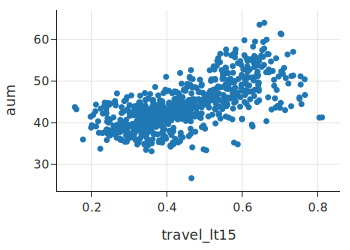

In [4]:
px.scatter(cz_df, x='travel_lt15', y='aum',
           width=350, height=250)

In [5]:
from sklearn.linear_model import LinearRegression

cz_df[['aum', 'travel_lt15']].corr()

,aum,travel_lt15
aum,1.00,0.68
travel_lt15,0.68,1.00


In [6]:
y = cz_df[['aum']]
X = cz_df[['travel_lt15']]

slr_aum = LinearRegression().fit(X, y)

In [7]:
print(f"Intercept: {slr_aum.intercept_}  Slope: {slr_aum.coef_[0]}")

Intercept: [31.27]  Slope: [28.66]


In [8]:
print(f"R-square: {slr_aum.score(X, y):.2f}")

R-square: 0.46


In [9]:
predicted_aum = slr_aum.predict(X)
errors = y - predicted_aum

In [10]:
np.std(errors)

aum    4.14
dtype: float64

In [11]:
np.std(cz_df['aum'])

5.614675842001113

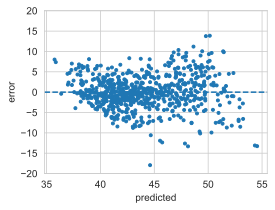

In [12]:
plt.plot(predicted_aum, errors, '.')
plt.xlabel("predicted")
plt.ylabel("error")
plt.ylim((-20, 20))
plt.axhline(y=0, linestyle='dashed')

:::{note}

We'll work with $ \epsilon $ more rigorously in future chapters.
For now, the important idea to remember is that the model depends on
$ x $. For example,
when $ \theta_1 $ is positive, bigger values of $ x $ make the
prediction $ f_{\theta}(x) $ bigger.

:::

## Relating Upward Mobility Using Multiple Variables

Before, we used the fraction of people with a ≤15 min commute time to predict
the AUM for a commuting zone.
Now, we'd like to use a combination of predictors.
In his original analysis, Chetty created nine high-level
predictor categories like segregation, income, and K-12 education.
We'll take one predictor from each of Chetty's categories for a total of
nine predictors, described in {numref}`Table %s <tbl:linear-predictors>`.

:::{table} The nine variables we use to predict AUM
:name: tbl:linear-predictors

| Column name | Description |
| ----------- | ----------- |
| frac_traveltime_lt15 | Fraction of people with a ≤15 minute commute to work.
| gini | Gini coefficient, an measure of wealth inequality. Values are between 0 and 1, where small values mean wealth is evenly distributed and large values mean more inequality.
| dropout_r | High school dropout rate.
| rel_tot | Fraction of people who self-reported as religious.
| cs_fam_wkidsinglemom | Fraction of children with a single mother.
| taxrate | Local tax rate.
| gradrate_r | College graduation rate.
| frac_worked1416 | Fraction of teenagers who are working.
| cs_born_foreign | Fraction of people born outside the US.
:::

Our original dataframe has around 40 predictors.
We take a subset of the columns in the dataframe to create a design matrix $\textbf{X}$ and
we extract the column of outcomes into a Series $\mathbf{y}$.

In [13]:
X2 = cz_df[['travel_lt15', 'single_mom']]
     
y = cz_df[['aum']]

model2 = LinearRegression().fit(X2, y)

In [14]:
print(f"Intercept: {model2.intercept_[0]:.1f}, \ntravel lt 15 min coefficient: {model2.coef_[0][0]:.2f},  \nfraction of single moms coefficient: {model2.coef_[0][1]:.2f}")

Intercept: 49.0, 
travel lt 15 min coefficient: 18.10,  
fraction of single moms coefficient: -63.98


In [15]:
predicted2 = model2.predict(X2)
errors2 = y - predicted2

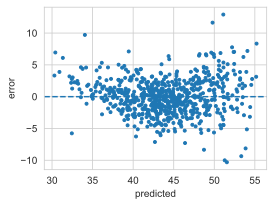

In [16]:
plt.plot(predicted2, errors2, '.')
plt.xlabel("predicted")
plt.ylabel("error")
#plt.ylim((-12, 12))
plt.axhline(y=0, linestyle='dashed')

In [17]:
np.std(errors2)

aum    2.85
dtype: float64

In [18]:
print(f"R-square: {model2.score(X2, y):.2f}")

R-square: 0.74


In [19]:
print(f'Design-matrix X has shape: {X.shape}')
print(f'Response y has length: {y.shape}')

Design-matrix X has shape: (705, 1)
Response y has length: (705, 1)


Let's look at `X`, a dataframe that we're using as our design matrix.
It has 479 observations and 9 predictors plus an intercept column:

In [20]:
predictors = [
    'travel_lt15', 'gini', 'rel_tot', 'single_mom', 
    'taxrate', 'worked_14', 'foreign'
]

cz_df[(['aum'] + predictors)].corr()

,aum,travel_lt15,gini,rel_tot,single_mom,taxrate,worked_14,foreign
aum,1.00,0.68,-0.60,0.52,-0.77,0.35,0.65,-0.03
travel_lt15,0.68,1.00,-0.56,0.40,-0.42,0.34,0.60,-0.19
gini,-0.60,-0.56,1.00,-0.29,0.57,-0.15,-0.58,0.31
...,...,...,...,...,...,...,...,...
taxrate,0.35,0.34,-0.15,0.08,-0.26,1.00,0.35,0.26
worked_14,0.65,0.60,-0.58,0.28,-0.60,0.35,1.00,-0.15
foreign,-0.03,-0.19,0.31,-0.11,-0.04,0.26,-0.15,1.00


Notice that our design matrix is a subset of our original dataframe---we just
selected specific variables we want to use for prediction.
Each row of our design matrix corresponds to an observation in our original
data, and each column corresponds to a predictor variable.


:::{note}

Once again, we'll point out that people from different backgrounds use
different terminology.
For example, we say that each row in the design matrix $X$ is an observation
and each column is a variable.
This is more common among people with backgrounds in statistics.
Others say that each column of the design matrix represents a *feature*.
Also, we say that our overall process of fitting and interpreting models
is called *modeling*, while others call it *machine learning*.

:::

Now, let's fit a multiple linear model.
Recall that we're using nine variables to predict AUM, the upward mobility for
a commuting zone.
As with the simple linear model, we'll split our data into a training set and 
a test set.

To understand this error, we can start by comparing the multiple linear model
with the simple linear model from before that only used the fraction with
≤15 min commute time.

We see that the multiple linear model has about 60% lower error than the simple
linear model---a big improvement!
Let's make residual plots for both multiple and simple linear models.

In [21]:
X7 = cz_df[predictors]

model7 = LinearRegression().fit(X7, y)

In [22]:
predicted7 = model7.predict(X7)
errors7 = y - predicted7

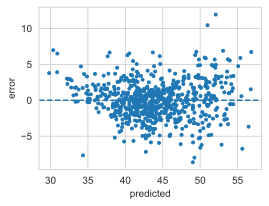

In [23]:
plt.plot(predicted7, errors7, '.')
plt.xlabel("predicted")
plt.ylabel("error")
#plt.ylim((-12, 12))
plt.axhline(y=0, linestyle='dashed')

In [24]:
np.std(errors7)

aum    2.59
dtype: float64

In [25]:
print(f"R-square: {model7.score(X7, y):.2f}")

R-square: 0.79


We can see that the multiple linear model's residuals are much closer to 0
in general, which helps to explain why the MSE is also lower.

Now, let's look at our multiple linear model.
Since our model has 7 predictor variables, we'll show the model coefficients in
a table rather than writing out the long model equation:

In [26]:
model7.coef_

array([[ 12.56,  -3.67,   7.65, -52.18,  36.57, 352.18,   4.94]])

Let's look at the coefficient for `gradrate_r`, the college graduation rate.
For a multiple linear model, we interpret this coefficient as saying:
if we took two commuting zones that are the same in all predictors except 
`gradrate_r`, the model predicts that the commuting zone with a 0.1 larger
`gradrate_r` also has a 0.051 higher AUM.
The key difference for multiple linear models is that
we only have a useful interpretation for a coefficient when we can
hold the other predictors constant.

Unfortunately, this is not always the case.
As an extreme example, let's say our model happened to have an extra
predictor `2 * gradrate_r` which doubles each value from `gradrate_r`.
If our model had this predictor, it doesn't make sense to talk about
`gradrate_r`'s coefficient since we can't hold `2 * gradrate_r` constant.
In general, we need to watch out for *collinearity*, where two predictor
variables are highly correlated with each other.
If our model has variables with high collinearity, we can't make useful
interpretations for the model coefficients.

To check for collinearity, we can look at the correlations between each pair
of predictors, as shown in the heatmap below.

We see that `cs_fam_wkidsinglemom`, the fraction of families with a single mom,
has a high correlation with several other predictors, like `gini` and
`frac_worked1416`.
Here, we face a central tension in modeling.
If we want the most interpretable model, we should try to avoid collinearity.
For instance, we could remove variables that are highly correlated with others.
However, doing this often makes our model less accurate.
Having an interpretable model can mean having a less accurate model.
Is is better to have a highly interpretable model or a highly accurate one?
It depends.
Each modeling situation needs a different tradeoff, and it's the
job of the data scientist to understand and make this tradeoff.

So far, our model requires all of the predictor variables to be numeric.
But categorical data is often useful for prediction as well.